In [1]:
run '../__init__.py'

In [2]:
import numpy as np
import networkx as nx
import cvxpy as cp

# import warnings
# warnings.filterwarnings("ignore")

import scipy.io as sio
from sodapy import Socrata

In [3]:
APP_TOKEN = os.getenv("APP_TOKEN")
client = Socrata("data.cityofnewyork.us", APP_TOKEN, timeout=3600)

# Matrix Completion: Chelsea

In [4]:
endpoint = "7ym2-wayt"

query = "SELECT COUNT(*)"
NUM_RECORDS = int(client.get(endpoint, query=query)[0]['COUNT'])
NUM_RECORDS

27414481

## Helper Functions

In [5]:
def request_atr_series(ids):
    
    query = f"""
        SELECT *
        WHERE segmentid IN ({', '.join(map(str, ids))})
        AND yr = 2019
        LIMIT {NUM_RECORDS}
    """
    
    # query = f"""
    #     SELECT *
    #     WHERE segmentid IN ({', '.join(map(str, ids))})
    #     LIMIT {NUM_RECORDS}
    # """    
    
    df = pd.DataFrame.from_records(client.get(endpoint, query=query))

    df['ts'] = pd.to_datetime(df[['yr', 'm', 'd', 'hh', 'mm']]\
                 .apply(lambda row: '-'.join(row), axis=1), format='%Y-%m-%d-%H-%M')
    df = df.astype({'vol':float})   
    
    
    gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df.wktgeom, crs="ESRI:102718")).drop(columns=['wktgeom'])
    gdf = gdf.to_crs(4326)
    
    gdf['segment_direction'] = df.segmentid + '-' + df.direction
    
    return gdf

In [6]:
# intersection = set(df[df.vol>0].ts)
# for ts_set in df.groupby('segment_direction').ts.apply(set):
#     intersection = intersection & ts_set
    
# df = df[df.ts.between(min(intersection), max(intersection))]


def clean_atr(df, outflows, dt_range=('2019-06-05', '2019-06-07')):
    
    # Data Cleaning
    df = df[['segment_direction', 'geometry', 'boro', 'street', 'fromst', 'tost', 'direction', 'ts', 'vol']]
    
    if dt_range:
        df = df[df.ts.between(*dt_range)]
    
    # Mark flow types as infow or outflow
    df['flow_type'] = 'inflow'
    df.loc[df.segment_direction.isin(outflows), 'flow_type'] = 'outflow'
    # Set outflows as negative volumes
    df['flow'] = df.vol.copy()
    df.loc[df.flow_type=='outflow', 'flow'] *= -1
    
    return df
    

In [7]:
def calculate_backlog(df):
    
    in_out = df.groupby(['ts', 'flow_type']).vol.sum().reset_index()
    
    net = df.groupby('ts').flow.sum().to_frame('vol').reset_index()
    net['flow_type'] = 'netflow'
    
    backlog = df.groupby('ts').flow.sum().cumsum().to_frame('vol').reset_index()
    backlog['flow_type'] = 'backlog'
    
    return pd.concat([in_out, net, backlog])

In [8]:
df = request_atr_series([32462, 32467, 32814,
                         32811, 32798, 32795,
                         32628, 32634, 32632,
                         32460, 32458, 271225,
                         32299, 32301, 32463])

## Networkx Visualization

### Manual

In [9]:
G = nx.Graph()

In [10]:
G.add_nodes_from(['18st/8ave', '18st/7ave', '18st/6ave',
                  '17st/8ave', '17st/7ave', '17st/6ave',
                  '16st/8ave', '16st/7ave', '16st/6ave',
                  '15st/8ave', '15st/7ave', '15st/6ave',
                  'external'])

In [11]:
edges = [('external', '18st/8ave'), ('17st/8ave', 'external'),  ('external', '16st/8ave'), ('15st/8ave', 'external'),
         ('external', '15st/8ave'), ('15st/8ave', '16st/8ave'), ('16st/8ave', '17st/8ave'), ('17st/8ave', '18st/8ave'),
         ('18st/8ave', '18st/7ave'), ('17st/7ave', '17st/8ave'), ('16st/8ave', '16st/7ave'), ('15st/7ave', '15st/8ave'),
         ('external', '18st/7ave'), ('18st/7ave', '17st/7ave'), ('17st/7ave', '16st/7ave'), ('16st/7ave', '15st/7ave'),
         ('18st/7ave', '18st/6ave'), ('17st/6ave', '17st/7ave'), ('16st/7ave', '16st/6ave'), ('15st/6ave', '15st/7ave'),
         ('external', '15st/6ave'), ('15st/6ave', '16st/6ave'), ('16st/6ave', '17st/7ave'), ('17st/7ave', '18st/7ave'),
         ('18st/6ave', 'external'), ('external', '17st/6ave'), ('16st/6ave', 'external'), ('external', '15st/6ave')]
for e in edges:
    G.add_edge(*e)

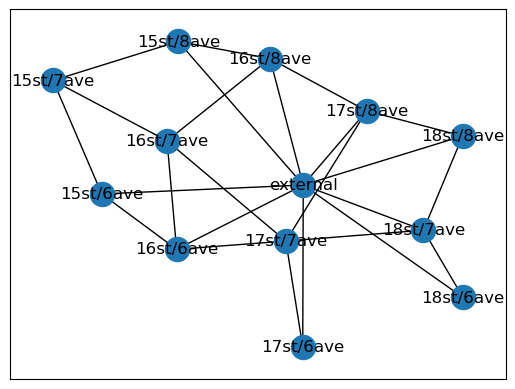

In [12]:
nx.draw_networkx(G)

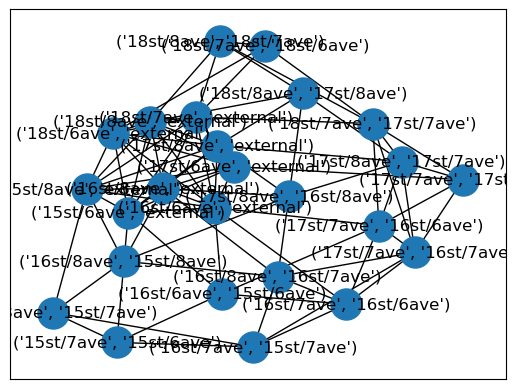

In [13]:
# Dual graph holy
G_prime=nx.line_graph(G)
nx.draw_networkx(G_prime, node_size=500)

In [14]:
L = nx.laplacian_matrix(G).todense()
L_prime = nx.laplacian_matrix(G_prime).todense()

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


### Grid

In [15]:
G = nx.grid_2d_graph(5, 6)

In [16]:
for n in [(0, 0), (4, 0), (4, 5), (0, 5)]:
    G.remove_node(n)

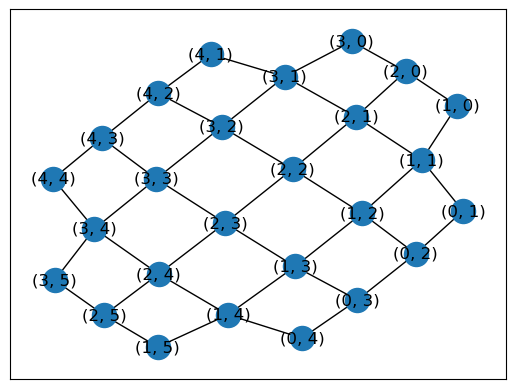

In [17]:
nx.draw_networkx(G)

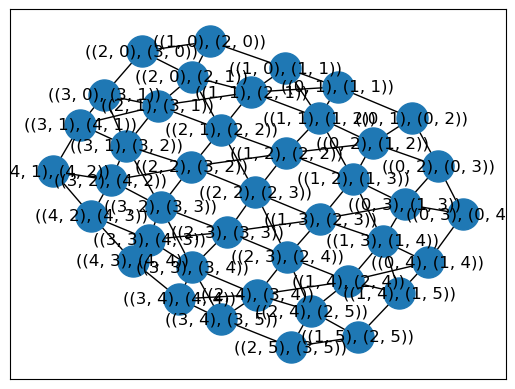

In [18]:
# Dual graph holy
G_prime=nx.line_graph(G)
nx.draw_networkx(G_prime, node_size=500)

In [19]:
L = nx.laplacian_matrix(G).todense()
L_prime = nx.laplacian_matrix(G_prime).todense()

## CVXPY

Minimize $$||\bar{\Omega} \odot (\bar{F} - \bar{F_c})||_F^2 + ||\Omega \odot (F - F_c)||_F^2 + \lambda_1||\bar{F}L'F||_F + \lambda_2||FL'\bar{F}||_F + \lambda_3||\bar{F}(:, t+1) - \bar{F}(:, t)||_F + \lambda_4||F(:, t+1) - F(:, t)||_F + \lambda_5||\bar{F} - F||_F$$
s.t.
1. $F_c, \bar{F_c} > 0$
2. $F_c, \bar{F_c}$ contain integer elements
3. $P(t+1) = P(t) + \bar{F}(t) - F(t)$

In [20]:
# F_in = np.random.randint(low=1, high=10, size=(4, 2))
F_in = np.array([[4, 8, 5],
                 [0, 0, 10],
                 [2, 0, 8],
                 [5, 2, 6]])
# F_out = np.random.randint(low=1, high=10, size=(4, 2))
F_out = np.array([[3, 2, 2],
                  [5, 7, 1],
                  [5, 0, 3],
                  [0, 5, 4]])
print(F_in.shape)

(4, 3)


In [21]:
omega_in = np.array([[1, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]])
omega_out = np.array([[1, 1, 1], [1, 1, 1], [1, 0, 1], [0, 1, 1]])

In [22]:
l1, l2, l3, l4, l5 = 1, 1, 1, 1, 1

In [23]:
F_in_c = cp.Variable((4, 3))
F_out_c = cp.Variable((4, 3))

In [24]:
# P = np.array([[1, 2],
#               [1, 1],
#               [4, 1],
#               [1, 1]])

P = cp.Variable((4, 3))

$$||\bar{\Omega} \odot (\bar{F} - \bar{F_c})||_F^2 + ||\Omega \odot (F - F_c)||_F^2$$

In [25]:
expr1 = cp.square(cp.atoms.norm(cp.multiply(omega_in, (F_in - F_in_c)), p='fro'))
expr2 = cp.square(cp.atoms.norm(cp.multiply(omega_out, (F_out - F_out_c)), p='fro'))

$$\lambda_1||\bar{F}^\intercal L'F||_F + \lambda_2||F^\intercal L'\bar{F}||_F$$

In [26]:
expr3 = l1 * cp.atoms.norm(F_in.T @ L_prime @ F_out, p='fro')
expr4 = l2 * cp.atoms.norm(F_out.T @ L_prime @ F_in, p='fro')

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 41 is different from 4)

$$\lambda_3||\bar{F}(:, t+1) - \bar{F}(:, t)||_F + \lambda_4||F(:, t+1) - F(:, t)||_F$$

In [ ]:
# expr5 = l3 * cp.atoms.norm(F_in - np.pad(F_in[:, 1:], pad_width=((0, 0),(0, 1))), p='fro')
# expr6 = l4 * cp.atoms.norm(F_out - np.pad(F_out[:, 1:], pad_width=((0, 0),(0, 1))), p='fro')

expr5 = l3 * cp.atoms.norm(F_in[:, 1:] - F_in[:, :-1], p='fro')
expr6 = l4 * cp.atoms.norm(F_out[:, 1:] - F_out[:, :-1], p='fro')

$$\lambda_5||\bar{F} - F||_F$$

In [ ]:
expr7 = l5 * cp.atoms.norm(F_in - F_out, p='fro')

Constraint 1: $F_c, \bar{F_c} > 0$

In [ ]:
# Define the constraints
constraints = [
    F_in_c >= 0,  # Ensure each element of F_in_c is positive
    F_out_c >= 0  # Ensure each element of F_out_c is positive
    # assert for Parking matrix to be positive
]

In [ ]:
# P + np.pad(F_in_c.value[:, 1:], pad_width=((0, 0), (1, 0))) - np.pad(F_out_c.value[:, 1:], pad_width=((0, 0), (1, 0)))

Minimize

In [ ]:
problem = cp.Problem(objective=cp.Minimize(expr1 + expr2 + expr3 + expr4 + expr5 + expr6 + expr7),
                     constraints=constraints)
problem.solve()

In [ ]:
F_in_c.value

In [ ]:
F_out_c.value

In [ ]:
F_in_c.value - F_out_c.value